# data format
each training sample is going to be:
1 RGB image
16 joints coordinate of 2d

In [5]:
import os

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms


class HandJointsPngAndCsvDataset(Dataset):
    def __init__(self, image_dir, joint_dir, image_size=(512, 512)):
        self.image_dir = image_dir
        self.joint_dir = joint_dir
        self.image_size = image_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_file = image_file.replace(".png", "_joints2d.csv")
        label_path = os.path.join(self.joint_dir, label_file)

        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)

        joint_df = pd.read_csv(label_path)
        coords = joint_df[['u', 'v']].values.astype(np.float32)
        coords /= self.image_size[0]

        return img, torch.tensor(coords)


# load the data

In [6]:
image_dir = '../../../scripts/auto_generator/ply2obj2img'
label_dir = '../../../scripts/auto_generator/ply2obj2img'

dataset = HandJointsPngAndCsvDataset(image_dir, label_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

img, joints = dataset[0]
print(img.shape)
print(joints.shape)

torch.Size([3, 512, 512])
torch.Size([16, 2])


# define the model

In [7]:
class MyHandEstimator(nn.Module):
    def __init__(self, num_joints=16):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),  # output 128*128
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  # output 64*64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # output 32*32
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_joints * 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x.view(-1, 16, 2)


# compute the pixel error

In [8]:
import numpy as np


def compute_pixel_error(pred, gt, image_size=512):
    """
    Compute mean pixel error between predicted and ground-truth joint positions.

    Args:
        pred (np.ndarray): shape (16, 2), normalized predicted coordinates (0~1)
        gt (np.ndarray): shape (16, 2), normalized ground truth (0~1)
        image_size (int): width/height in pixels

    Returns:
        float: average Euclidean distance in pixels
    """
    pred_px = pred * image_size
    gt_px = gt * image_size

    pixel_distances = np.linalg.norm(pred_px - gt_px, axis=1)
    return np.mean(pixel_distances), pixel_distances

# training loop

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyHandEstimator().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    avg_pixel_error = 0
    pixel_error_count = 0
    for imgs, joints in dataloader:
        imgs = imgs.to(device)
        joints = joints.to(device)

        preds = model(imgs)
        loss = criterion(preds, joints)

        optimizer.zero_grad()
        loss.backward()

        with torch.no_grad():
            pred_np = preds.cpu().numpy().reshape(-1, 16, 2)
            gt_np = joints.cpu().numpy().reshape(-1, 16, 2)

            for p, g in zip(pred_np, gt_np):
                error = np.linalg.norm((p - g) * 512, axis=1)  # pixel error per joint
                avg_pixel_error += np.mean(error)
                pixel_error_count += 1

        optimizer.step()

        total_loss += loss.item()

    avg_px_err = avg_pixel_error / pixel_error_count
    print(f"Epoch [{epoch + 1}/{n_epochs}] Loss: {total_loss / len(dataloader):.6f} | PixelErr: {avg_px_err:.2f}px")

Epoch [1/30] Loss: 0.017426 | PixelErr: 52.09px
Epoch [2/30] Loss: 0.000486 | PixelErr: 14.07px
Epoch [3/30] Loss: 0.000505 | PixelErr: 14.32px
Epoch [4/30] Loss: 0.000513 | PixelErr: 14.42px
Epoch [5/30] Loss: 0.000502 | PixelErr: 14.31px
Epoch [6/30] Loss: 0.000503 | PixelErr: 14.32px
Epoch [7/30] Loss: 0.000512 | PixelErr: 14.45px
Epoch [8/30] Loss: 0.000573 | PixelErr: 15.35px
Epoch [9/30] Loss: 0.000540 | PixelErr: 14.82px
Epoch [10/30] Loss: 0.000532 | PixelErr: 14.57px
Epoch [11/30] Loss: 0.000570 | PixelErr: 15.32px
Epoch [12/30] Loss: 0.000552 | PixelErr: 15.01px
Epoch [13/30] Loss: 0.000527 | PixelErr: 14.63px
Epoch [14/30] Loss: 0.000599 | PixelErr: 15.70px
Epoch [15/30] Loss: 0.000534 | PixelErr: 14.79px
Epoch [16/30] Loss: 0.000536 | PixelErr: 14.78px
Epoch [17/30] Loss: 0.000590 | PixelErr: 15.53px
Epoch [18/30] Loss: 0.000553 | PixelErr: 14.99px
Epoch [19/30] Loss: 0.000563 | PixelErr: 15.16px
Epoch [20/30] Loss: 0.000547 | PixelErr: 14.86px
Epoch [21/30] Loss: 0.000518 

# visualize predicted vs label

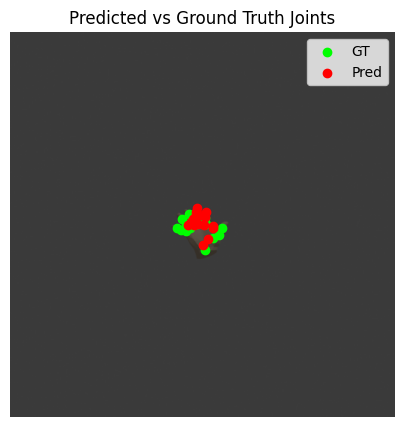

In [10]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    img_tensor, gt = dataset[0]
    input_tensor = img_tensor.unsqueeze(0).to(device)  # add batch dim
    pred = model(input_tensor).cpu()[0].numpy()  # shape: (16, 2)

gt_pixels = gt.numpy() * 512
pred_pixels = pred * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()

# save the model

In [11]:
save_path = "checkpoints/hand_joint_model.pth"
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to checkpoints/hand_joint_model.pth


# compare with mediapipe


In [12]:
from PIL import Image
from torchvision import transforms


def predict_with_my_model(image_path, model, image_size=(256, 256), device="cpu"):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)[0].cpu().numpy()  # (16, 2)

    return output * 512, image  # Denormalize and return

In [13]:
import mediapipe as mp
import cv2


def predict_with_mediapipe(image_path):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)
    landmarks = []

    if results.multi_hand_landmarks:
        for lm in results.multi_hand_landmarks[0].landmark[:16]:  # only first 16 joints
            landmarks.append([lm.x * 512, lm.y * 512])

    hands.close()
    return np.array(landmarks), Image.fromarray(image_rgb)

I0000 00:00:1753801214.802699 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753801214.832266 33855462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753801214.838976 33855462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753801214.863714 33855467 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


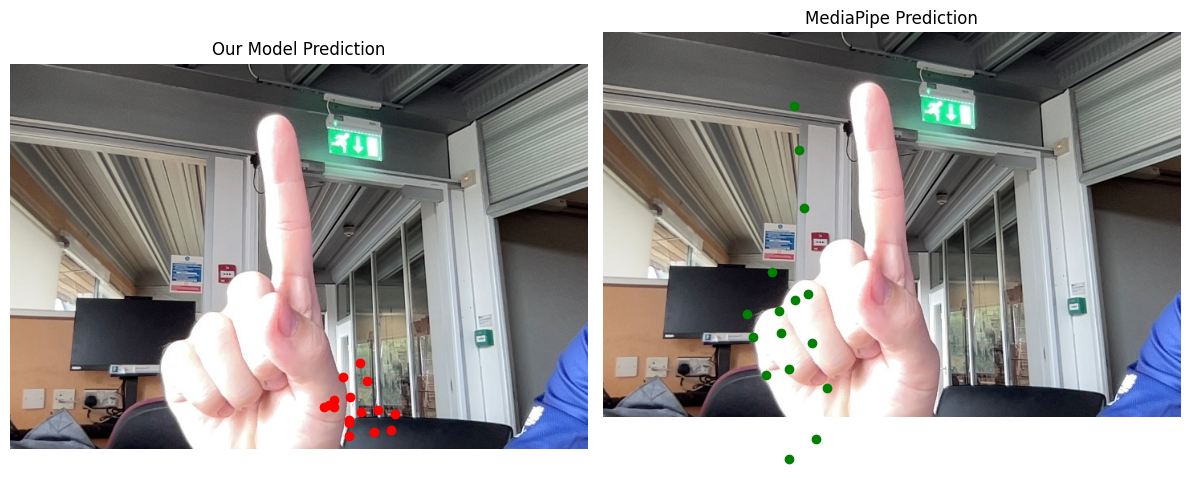

In [14]:
import matplotlib.pyplot as plt


def compare_predictions(img_path, model, device="cpu"):
    pred_ours, img = predict_with_my_model(img_path, model, device=device)
    pred_mp, _ = predict_with_mediapipe(img_path)

    plt.figure(figsize=(12, 6))

    # Ours
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.scatter(pred_ours[:, 0], pred_ours[:, 1], c='red')
    plt.title("Our Model Prediction")
    plt.axis('off')

    # MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    if len(pred_mp) == 16:
        plt.scatter(pred_mp[:, 0], pred_mp[:, 1], c='green')
        plt.title("MediaPipe Prediction")
    else:
        plt.title("MediaPipe Prediction (Not Detected)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


compare_predictions('../../../docs/gesture_design/img.png', model, device)

I0000 00:00:1753801215.206449 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1753801215.213661 33855530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753801215.219269 33855530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


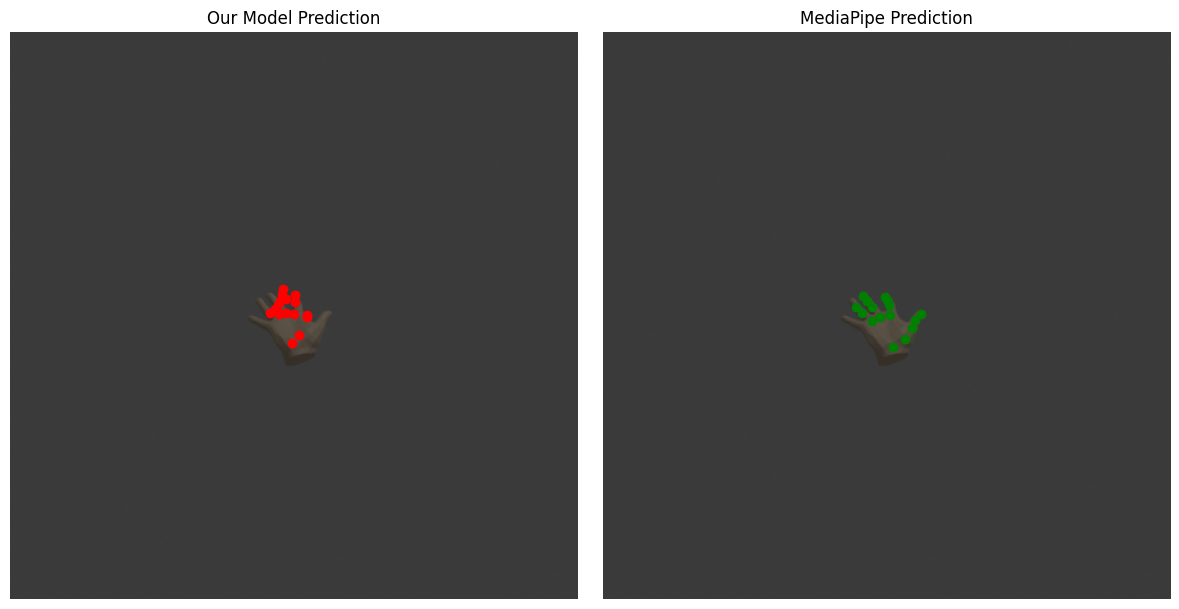

In [15]:
compare_predictions('../../../scripts/auto_generator/ply2obj2img/01_01r.png', model, device)